<h1>Capstone Project - The Battle of Neighborhoods</h1>

## Introduction: Business Problem

The aim of this project is to find a safe and secure location for opening of a Japanese restaurant in Toronto, Canada. 

The first task would be to **choose the safest borough** by analysing crime data for opening a restaurant and **short listing a neighborhood**, where Japanese restaurants are not amongst the most commom venues, and yet **as close to the city as possible**.

Also, our Japanese restaurant target customers will have a **Average to above average median net household incomes**.


## Data Needed & Methodology

Following data sources will be needed to extract/generate the required information:

1. Toronto crime data from 2014 - 2019. 
https://www.kaggle.com/kapastor/toronto-police-data-crime-rates-by-neighbourhood

2.  City of Toronto Neighborhood Profiles for providing an overview of the neighborhoods in Toronto.  
https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/neighbourhood-profiles/

3. City of Toronto Open Data Catalogue. 
https://open.toronto.ca/#8c732154-5012-9afe-d0cd-ba3ffc813d5a

4. Foursquare API to collect information on other venues/competitors in the neighborhoods of Toronto.

We will extract all the needed data from the above url, and analyze them with the requirement listed in the introduction session.

In [1]:
import numpy as np
import pandas as pd
!pip install lxml
!pip install beautifulsoup4
#Command to install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

print('Libraries imported')

Matplotlib version:  3.1.1
Libraries imported


In [2]:
#explore the crime dataset
to_crime_df = pd.read_csv('MCI_2014_to_2019.csv', index_col=None)

to_crime_df.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-79.405228,43.656982,7801,GO-20152165447,2015-12-18T03:58:00.000Z,2015-12-18T03:59:00.000Z,Commercial,1430,100,Assault,...,352.0,Friday,3,Assault,D14,79,University (79),-79.405228,43.656982,7001
1,-79.307907,43.778732,7802,GO-20151417245,2015-08-15T21:45:00.000Z,2015-08-17T22:11:00.000Z,Commercial,1430,100,Assault,...,227.0,Saturday,21,Assault,D42,118,Tam O'Shanter-Sullivan (118),-79.307907,43.778732,7002
2,-79.225029,43.765942,7803,GO-20151421107,2015-08-16T16:00:00.000Z,2015-08-18T14:40:00.000Z,Apartment,2120,200,B&E,...,228.0,Sunday,16,Break and Enter,D43,137,Woburn (137),-79.225029,43.765942,7003
3,-79.140823,43.778648,7804,GO-20152167714,2015-11-26T13:00:00.000Z,2015-12-18T13:38:00.000Z,Other,2120,200,B&E,...,330.0,Thursday,13,Break and Enter,D43,133,Centennial Scarborough (133),-79.140823,43.778648,7004
4,-79.288361,43.691235,7805,GO-20152169954,2015-12-18T19:50:00.000Z,2015-12-18T19:55:00.000Z,Commercial,1430,100,Assault,...,352.0,Friday,19,Assault,D55,61,Taylor-Massey (61),-79.288361,43.691235,7005


In [3]:
#spliting the CDN numbers from the Neighbourhood column
to_crime_df[['Neighbourhood','CDN', 'NA']] = to_crime_df['Neighbourhood'].str.split("(", expand=True)
#focus on the crime area
to_crime_df['Neighbourhood'].value_counts()

Waterfront Communities-The Island     7747
Bay Street Corridor                   6817
Church-Yonge Corridor                 6232
West Humber-Clairville                5702
Moss Park                             4786
                                      ... 
Yonge-St.Clair                         412
Guildwood                              411
Maple Leaf                             410
Woodbine-Lumsden                       377
Lambton Baby Point                     353
Name: Neighbourhood, Length: 140, dtype: int64

In [4]:
#drop the unneeded columns
to_crime_df.drop(['X','Y', 'Index_',
                  'occurrencedate', 
                  'reporteddate', 
                  'ucr_code', 
                  'ucr_ext', 
                  'offence', 
                  'reportedmonth', 
                  'reportedday', 
                  'reporteddayofyear', 
                  'reporteddayofweek', 
                  'reportedhour', 
                  'reportedyear',
                  'event_unique_id',
                  'premisetype', 
                  'occurrencemonth', 
                  'occurrenceday', 
                  'occurrencedayofyear', 
                  'occurrencedayofweek', 
                  'occurrencehour', 
                  'Division', 
                  'Hood_ID', 
                  'ObjectId', 
                  'CDN', 'NA'], axis = 1, inplace = True)

In [5]:
to_crime_df.head()

,occurrenceyear,MCI,Neighbourhood,Long,Lat
0,2015.0,Assault,University,-79.405228,43.656982
1,2015.0,Assault,Tam O'Shanter-Sullivan,-79.307907,43.778732
2,2015.0,Break and Enter,Woburn,-79.225029,43.765942
3,2015.0,Break and Enter,Centennial Scarborough,-79.140823,43.778648
4,2015.0,Assault,Taylor-Massey,-79.288361,43.691235


In [6]:
to_crime_df.dtypes

occurrenceyear    float64
MCI                object
Neighbourhood      object
Long              float64
Lat               float64
dtype: object

In [7]:
to_crime_df.columns = ['Year', 'Offence', 'Neighbourhood', 'long', 'lat']
to_crime_df.head()

,Year,Offence,Neighbourhood,long,lat
0,2015.0,Assault,University,-79.405228,43.656982
1,2015.0,Assault,Tam O'Shanter-Sullivan,-79.307907,43.778732
2,2015.0,Break and Enter,Woburn,-79.225029,43.765942
3,2015.0,Break and Enter,Centennial Scarborough,-79.140823,43.778648
4,2015.0,Assault,Taylor-Massey,-79.288361,43.691235


In [8]:
to_crime_df = to_crime_df[['Neighbourhood','Year','Offence','long','lat']]
to_crime_df.head()

,Neighbourhood,Year,Offence,long,lat
0,University,2015.0,Assault,-79.405228,43.656982
1,Tam O'Shanter-Sullivan,2015.0,Assault,-79.307907,43.778732
2,Woburn,2015.0,Break and Enter,-79.225029,43.765942
3,Centennial Scarborough,2015.0,Break and Enter,-79.140823,43.778648
4,Taylor-Massey,2015.0,Assault,-79.288361,43.691235


In [9]:
to_crime_df.shape

(206435, 5)

In [10]:
to_crime_df.dtypes

Neighbourhood     object
Year             float64
Offence           object
long             float64
lat              float64
dtype: object

In [11]:
dfs = pd.read_html('https://en.wikipedia.org/wiki/List_of_city-designated_neighbourhoods_in_Toronto')
df_borough = dfs[0]
df_borough.head()

,CDN number,City-designated neighbourhood,Former city/borough,Neighbourhoods covered,Map,Unnamed: 5
0,129,Agincourt North,Scarborough,Agincourt and Brimwood,NaN,NaN
1,128,Agincourt South-Malvern West,Scarborough,Agincourt and Malvern,NaN,NaN
2,20,Alderwood,Etobicoke,Alderwood,NaN,NaN
3,95,Annex,Old City of Toronto,The Annex and Seaton Village,NaN,NaN
4,42,Banbury-Don Mills,North York,Don Mills,NaN,NaN


In [12]:
#drop the unneeded columns
df_borough.drop(['CDN number', 'Neighbourhoods covered', 'Map', 'Unnamed: 5'], axis = 1, inplace = True)

In [13]:
df_borough.columns = ['Neighbourhood', 'borough']
df_borough.head()

,Neighbourhood,borough
0,Agincourt North,Scarborough
1,Agincourt South-Malvern West,Scarborough
2,Alderwood,Etobicoke
3,Annex,Old City of Toronto
4,Banbury-Don Mills,North York


In [14]:
df_borough.dtypes

Neighbourhood    object
borough          object
dtype: object

In [15]:
to_crime_df['Neighbourhood'] = to_crime_df['Neighbourhood'].str.strip()
df_borough['Neighbourhood'] = df_borough['Neighbourhood'].str.strip()

new_table = to_crime_df.merge(df_borough, on='Neighbourhood')

In [16]:
display(new_table)

,Neighbourhood,Year,Offence,long,lat,borough
0,University,2015.0,Assault,-79.405228,43.656982,Old City of Toronto
1,University,2015.0,Break and Enter,-79.409767,43.661518,Old City of Toronto
2,University,2015.0,Assault,-79.403870,43.666660,Old City of Toronto
3,University,2015.0,Assault,-79.407471,43.665916,Old City of Toronto
4,University,2015.0,Assault,-79.400047,43.657951,Old City of Toronto
...,...,...,...,...,...,...
196603,Maple Leaf,2019.0,Auto Theft,-79.484520,43.716564,North York
196604,Maple Leaf,2019.0,Auto Theft,-79.475952,43.722732,North York
196605,Maple Leaf,2019.0,Auto Theft,-79.475952,43.722732,North York
196606,Maple Leaf,2019.0,Auto Theft,-79.491783,43.718124,North York


In [17]:
dups_neig = new_table.pivot_table(index=['Neighbourhood'], aggfunc='size')

dups_neig

Neighbourhood
Agincourt North                 1157
Agincourt South-Malvern West    1650
Alderwood                        545
Annex                           2917
Banbury-Don Mills               1205
                                ... 
Woodbine-Lumsden                 377
Wychwood                         801
Yonge-St.Clair                   412
York University Heights         3989
Yorkdale-Glen Park              1998
Length: 132, dtype: int64

Text(0.5, 0, 'Neighbourhood')

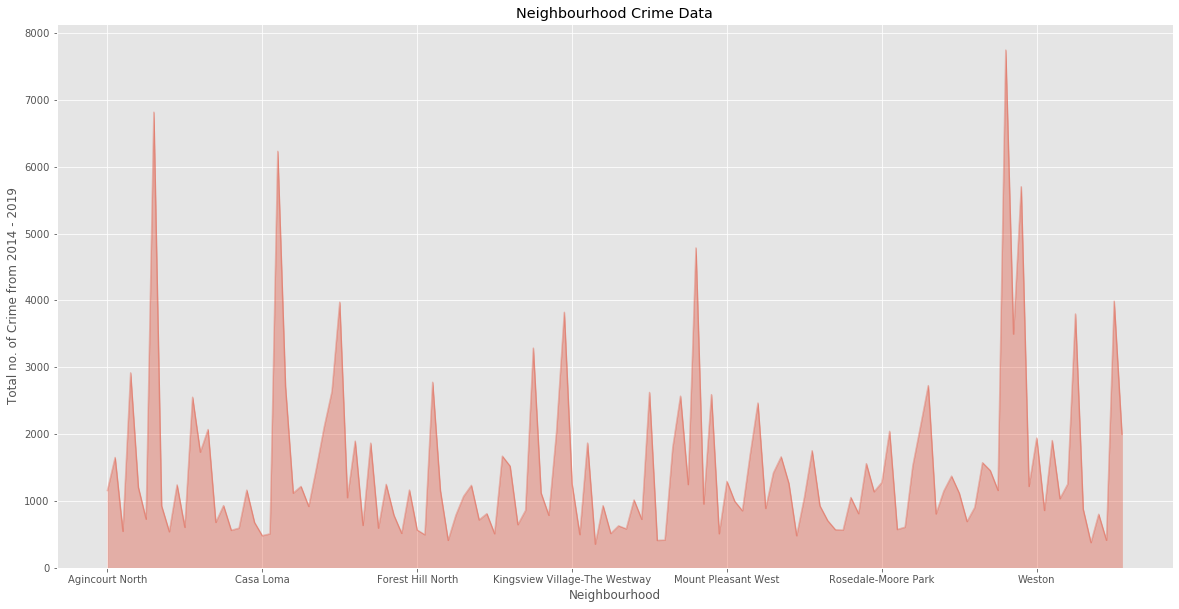

In [18]:
ax = dups_neig.plot(kind='area', alpha=0.35, figsize=(20, 10))

ax.set_title('Neighbourhood Crime Data')
ax.set_ylabel('Total no. of Crime from 2014 - 2019')
ax.set_xlabel('Neighbourhood')

In [19]:
dups_neig.columns = ['Neighbourhood', 'Count']

By exploring the dataset, the Top 10 safest Neighbourhood would be,

1. Lambton Baby Point
2. Woodbine-Lumsden
3. Maple Leaf
4. Guildwood
5. Yonge-St.Clair
6. Markland Wood
7. Old East York
8. Casa Loma
9. Forest Hill South
10. Kingsway South

We will now explore the household income by neighbourhood.


In [20]:
to_raw_df = pd.read_csv('neighbourhood-profiles-2016-csv.csv', index_col=None)

to_raw_df.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [21]:
to_income_df = to_raw_df.loc[to_raw_df['_id'] == 1030]


In [22]:
to_income_df

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
1029,1030,Income,Income of households in 2015,Census Profile 98-316-X2016001,Average after-tax income of households in 20...,"81,495","427,037","278,390","168,602","792,507",...,"272,986","412,302","629,030","240,272","147,462","239,484","222,648","541,217","302,358","213,860"


In [23]:
raw_data = {'Neighbourhood': ['Lambton Baby Point', 
                                         'Woodbine-Lumsden', 
                                         'Maple Leaf', 
                                         'Guildwood',
                                         'Yonge-St.Clair', 
                                         'Markland Wood', 
                                         'Old East York', 
                                         'Casa Loma', 
                                         'Forest Hill South', 
                                         'Kingsway South'],
                       'Income': [214945, 147462, 144062, 177062, 541217, 195412, 257522, 545338, 784645, 900624]}

safe_area_income_df = pd.DataFrame(raw_data)

safe_area_income_df.head()

,Neighbourhood,Income
0,Lambton Baby Point,214945
1,Woodbine-Lumsden,147462
2,Maple Leaf,144062
3,Guildwood,177062
4,Yonge-St.Clair,541217


In [24]:
safe_area_income_df = safe_area_income_df.sort_values(by=['Income'], ascending=False)
safe_area_income_df

,Neighbourhood,Income
9,Kingsway South,900624
8,Forest Hill South,784645
7,Casa Loma,545338
4,Yonge-St.Clair,541217
6,Old East York,257522
0,Lambton Baby Point,214945
5,Markland Wood,195412
3,Guildwood,177062
1,Woodbine-Lumsden,147462
2,Maple Leaf,144062


We can see that **Kingsway South**, **Forest Hill South**, **Casa Loma**, **Yonge-St.Clair**, are the top 4 highest income neighbourhoods among the safest neighbourhoods.

We will now use the Foursquare API to collect information on other venues/competitors in the neighborhoods of Toronto.

In [25]:
CLIENT_ID = 'MP1LZEW4EVDS2PIF10SMQ3WUKAIOIWGGRPGRW3DQ4F0CVLPY' # your Foursquare ID
CLIENT_SECRET = 'XFZ1NJD1K02Z04QRGVP2YGHNDOIUWLAZLMEWOYB2TDHA2M2I' # your Foursquare Secret
VERSION = '20180604'

In [26]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
from opencage.geocoder import OpenCageGeocode
from pprint import pprint

In [28]:
key = 'a78aaabbb46e4bd7b356130a444a209f'
geocoder = OpenCageGeocode(key)

In [29]:
query = u'Kingsway South, Toronto, Ontario'
results = geocoder.geocode(query)

print(u'%f;%f;%s;%s' % (results[0]['geometry']['lat'], 
                        results[0]['geometry']['lng'],
                        results[0]['components']['country_code'],
                        results[0]['annotations']['timezone']['name']))

43.647381;-79.511333;ca;America/Toronto


In [30]:
query = u'Forest Hill South, Toronto, Ontario'
results = geocoder.geocode(query)

print(u'%f;%f;%s;%s' % (results[0]['geometry']['lat'], 
                        results[0]['geometry']['lng'],
                        results[0]['components']['country_code'],
                        results[0]['annotations']['timezone']['name']))

43.693559;-79.413902;ca;America/Toronto


In [31]:
query = u'Casa Loma, Toronto, Ontario'
results = geocoder.geocode(query)

print(u'%f;%f;%s;%s' % (results[0]['geometry']['lat'], 
                        results[0]['geometry']['lng'],
                        results[0]['components']['country_code'],
                        results[0]['annotations']['timezone']['name']))

43.678101;-79.409416;ca;America/Toronto


In [32]:
query = u'Yonge-St.Clair, Toronto, Ontario'
results = geocoder.geocode(query)

print(u'%f;%f;%s;%s' % (results[0]['geometry']['lat'], 
                        results[0]['geometry']['lng'],
                        results[0]['components']['country_code'],
                        results[0]['annotations']['timezone']['name']))

43.688078;-79.394396;ca;America/Toronto


In [33]:
raw_data = {'Neighbourhood': ['Yonge-St.Clair', 'Casa Loma', 'Forest Hill South', 'Kingsway South'],
            'Latitude': [43.688078, 43.678101, 43.693559, 43.647381],
            'Longitude': [-79.394396, -79.409416, -79.413902, -79.511333]}

toronto_data = pd.DataFrame(raw_data)

In [34]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Yonge-St.Clair
Casa Loma
Forest Hill South
Kingsway South


In [35]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Casa Loma,22,22,22,22,22,22
Forest Hill South,4,4,4,4,4,4
Kingsway South,34,34,34,34,34,34
Yonge-St.Clair,60,60,60,60,60,60


In [36]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.insert(loc=0, column='Neighborhood', value=toronto_venues['Neighborhood'] )
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,American Restaurant,Bagel Shop,Bakery,Bank,Bar,Breakfast Spot,Burger Joint,Café,Cantonese Restaurant,...,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
0,Casa Loma,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.090909,0.000000,...,0.045455,0.000000,0.000000,0.000000,0.000000,0.00,0.045455,0.045455,0.000000,0.000000
1,Forest Hill South,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
2,Kingsway South,0.000000,0.000000,0.029412,0.058824,0.029412,0.058824,0.029412,0.029412,0.000000,...,0.000000,0.000000,0.058824,0.029412,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
3,Yonge-St.Clair,0.016667,0.033333,0.016667,0.033333,0.000000,0.016667,0.016667,0.066667,0.016667,...,0.000000,0.016667,0.050000,0.000000,0.016667,0.05,0.000000,0.000000,0.016667,0.016667


In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Casa Loma,Sandwich Place,Café,History Museum,Coffee Shop,Burger Joint,Museum,Middle Eastern Restaurant,Donut Shop,Pharmacy,Castle
1,Forest Hill South,Playground,Bank,Mediterranean Restaurant,Park,Yoga Studio,Indian Restaurant,History Museum,Historic Site,Gym,Grocery Store
2,Kingsway South,Coffee Shop,Breakfast Spot,Pub,Bank,Dessert Shop,Italian Restaurant,Sushi Restaurant,Gastropub,Mobile Phone Shop,French Restaurant
3,Yonge-St.Clair,Coffee Shop,Café,Italian Restaurant,Thai Restaurant,Grocery Store,Sushi Restaurant,Gym,Pub,Sandwich Place,Restaurant


## Results

By just looking to the table above, the **Forest Hill South** & **Casa Loma** maybe are the better options for opening a Japanese Sushi Restaurant, given all the restriction filtering as listed in the beginning.

## Discussion

Questions that can be asked using the above mentioned datasets,
- What is best location in Toronto for Japanese Cuisine ?
- Which areas have potential Japanese Restaurant Market (among the richest household in Toronto)?


Some limitation may affect the result of this study, 
 - The accuracy of data depends purely depends on the data provided by FourSquare
 - The household data and the crime data is not the most updated records.
 

## Conclusion

We can see that **Kingsway South**, **Forest Hill South**, **Casa Loma**, **Yonge-St.Clair**, are the top 4 highest income neighbourhoods among the safest neighbourhoods.
The **Forest Hill South** & **Casa Loma** maybe are the better options for opening a Japanese Sushi Restaurant, given all the restriction filtering as listed in the beginning.